In [1]:
dataset = 'mnist'
algorithm = 'ivis'
n_components = 2

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### load packages

In [5]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [7]:
from tensorflow.keras.datasets import mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### Create model and train

In [9]:
from ivis import Ivis
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

In [10]:
dims = (28,28,1)

In [11]:
def create_model():
    """model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(tf.keras.layers.Flatten())
    """
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    #tf.keras.layers.Dense(units=n_components),
    ])
    return model

In [12]:
base_model = create_model()

In [13]:
X_train.shape

(50000, 784)

In [14]:
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_train).reshape([len(X_train)] + list(dims))

In [15]:
# Set ivis parameters
model = Ivis(model=base_model, embedding_dims=2)

In [16]:
# Generate embeddings
embeddings =z = model.fit_transform(X_scaled)

  1%|          | 266/50000 [00:00<00:18, 2648.16it/s]

Building KNN index
Flattening multidimensional input before building KNN index using Annoy


100%|██████████| 50000/50000 [00:08<00:00, 5804.85it/s]


Extracting KNN neighbours
Flattening data before retrieving KNN from index


100%|██████████| 50000/50000 [00:13<00:00, 3836.37it/s] 


Training neural network
Epoch 1/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.1374
Epoch 2/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.1101
Epoch 3/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0984
Epoch 4/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0929
Epoch 5/1000
391/391 [==============================] - 3s 9ms/step - loss: 0.0917
Epoch 6/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0879
Epoch 7/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0882
Epoch 8/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0884
Epoch 9/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0871
Epoch 10/1000
391/391 [==============================] - 3s 8ms/step - loss: 0.0855
Epoch 11/1000
391/391 [==============================] - 3s 7ms/step - loss: 0.0840
Epoch 12/1000
391/391 [==============================] - 2s 6

### Plot model output

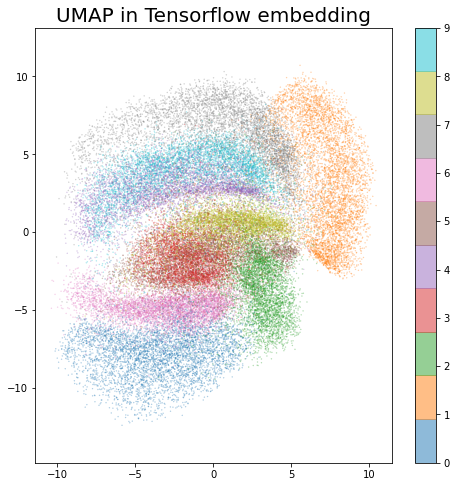

In [17]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [18]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [19]:
output_dir = MODEL_DIR/'projections'/ dataset / algorithm
ensure_dir(output_dir)

In [20]:
#vae.save(output_dir)

In [23]:
model.save_model(output_dir / 'iris.ivis')

In [24]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [25]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [26]:
X_test.shape

(10000, 784)

In [27]:
z_test = model.transform(x_scaler.transform(X_test).reshape([len(X_test)]+ list(dims)))

79/79 [==============================] - 0s 1ms/step


#### silhouette

In [28]:
from tfumap.silhouette import silhouette_score_block

In [29]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.07926893857092038

In [30]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.09142698211319449

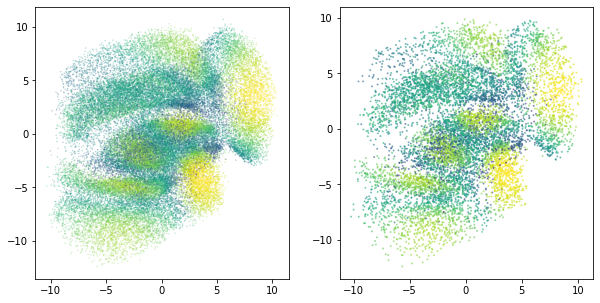

In [31]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.7009

In [34]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.6369

#### Trustworthiness

In [35]:
from sklearn.manifold import trustworthiness

In [36]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [37]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [38]:
tw, tw_test

(0.8747863010408327, 0.8719315512409929)

### Save output metrics

In [39]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [40]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,mnist,ivis,2,0.874786,0.079269,"[-0.2001182806404692, 0.3313471742542198, 0.11..."


In [41]:
save_loc = DATA_DIR / 'projection_metrics' /  algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [42]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,mnist,ivis,2,0.871932,0.091427,"[0.3522430621270159, 0.07405096509938247, 0.57..."


In [43]:
save_loc = DATA_DIR / 'projection_metrics' / algorithm / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [44]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = [algorithm, n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ivis,2,mnist,0.6369,0.7009


In [45]:
save_loc = DATA_DIR / 'knn_classifier' / algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [47]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [48]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, algorithm, z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,mnist,ivis,"[[-0.14289248, -1.5353576], [-1.979348, -8.964...","[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...",2


In [49]:
??get_cluster_metrics

In [50]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ivis_2_mnist.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,mnist,ivis,2,0.352001,0.380866,0.553720,0.451308,0,5,"KMeans(n_clusters=5, random_state=0)"
1,mnist,ivis,2,0.351788,0.380414,0.552883,0.450713,1,5,"KMeans(n_clusters=5, random_state=1)"
2,mnist,ivis,2,0.351988,0.380648,0.553366,0.451038,2,5,"KMeans(n_clusters=5, random_state=2)"
3,mnist,ivis,2,0.351983,0.380713,0.553441,0.451108,3,5,"KMeans(n_clusters=5, random_state=3)"
4,mnist,ivis,2,0.351701,0.380245,0.552586,0.450495,4,5,"KMeans(n_clusters=5, random_state=4)"
5,mnist,ivis,2,0.366995,0.448498,0.585035,0.507748,0,6,"KMeans(n_clusters=6, random_state=0)"
6,mnist,ivis,2,0.366455,0.443887,0.578646,0.502386,1,6,"KMeans(n_clusters=6, random_state=1)"
7,mnist,ivis,2,0.366898,0.445180,0.580482,0.503907,2,6,"KMeans(n_clusters=6, random_state=2)"
8,mnist,ivis,2,0.366673,0.447441,0.583724,0.506576,3,6,"KMeans(n_clusters=6, random_state=3)"
9,mnist,ivis,2,0.366644,0.447397,0.583668,0.506528,4,6,"KMeans(n_clusters=6, random_state=4)"
